In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json
import cv2
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

# Step 1: Connect to the database
db_path = "/Users/arijitdasgupta/Desktop/projects/red_green_completed_human_data/pilot2_v0_redgreen.db"  # Update with the path to your .db file
engine = create_engine(f"sqlite:///{db_path}")  # Assuming SQLite


# Step 2: Load session data and filter for complete sessions
session_query = """
    SELECT id AS session_id, randomized_trial_order
    FROM redgreen_session
    WHERE completed = 1
"""
session_df = pd.read_sql(session_query, engine)


# # Step 4: Load trial data and map `global_trial_name`
trial_query = """
    SELECT id AS trial_id, session_id, trial_index, global_trial_name, score
    FROM trial
    WHERE trial_type != 'ftrial' AND completed = 1
"""
trial_df = pd.read_sql(trial_query, engine)

# # Merge trials with session randomized order
merged_df = pd.merge(trial_df, session_df, left_on="session_id", right_on="session_id")


# Step 5: Load keystate data and filter for valid trials
valid_trial_ids = merged_df["trial_id"].dropna().tolist()

keystate_query = f"""
    SELECT ks.frame, ks.f_pressed, ks.j_pressed, ks.trial_id
    FROM keystate ks
    WHERE ks.trial_id IN ({', '.join(map(str, valid_trial_ids))})
"""
keystate_df = pd.read_sql(keystate_query, engine)

# Merge keystate data with global_trial_name
keystate_df = pd.merge(keystate_df, merged_df[["trial_id", "global_trial_name"]], on="trial_id")

# Step 6: Process the data
# Convert boolean to integer for aggregation
keystate_df["f_pressed"] = keystate_df["f_pressed"].astype(int)
keystate_df["j_pressed"] = keystate_df["j_pressed"].astype(int)

keystate_df["red"] = ((keystate_df["f_pressed"] == 1) & (keystate_df["j_pressed"] == 0)).astype(int)
keystate_df["green"] = ((keystate_df["j_pressed"] == 1) & (keystate_df["f_pressed"] == 0)).astype(int)
keystate_df["uncertain"] = ((keystate_df["j_pressed"] == 0) & (keystate_df["f_pressed"] == 0)
                            | (keystate_df["j_pressed"] == 1) & (keystate_df["f_pressed"] == 1)).astype(int)


# Group by global_trial_name and frame, calculate mean
aggregated_df = (
    keystate_df.groupby(["global_trial_name", "frame"])
    .mean(numeric_only=True)
    .reset_index()
)
aggregated_df.drop(columns=["trial_id"], inplace=True)

path_to_data = '/Users/arijitdasgupta/Desktop/projects/mental_physics_trials/pilot'


In [53]:
def plot_pair_with_video(trial_a_name, trial_a_data, trial_b_name, trial_b_data):
    # Path to the videos
    video_a_path = f"{path_to_data}/{trial_a_name}/high_res_obs.mp4"
    video_b_path = f"{path_to_data}/{trial_b_name}/high_res_obs.mp4"
    
    # Open the videos and preload all frames
    cap_a = cv2.VideoCapture(video_a_path)
    cap_b = cv2.VideoCapture(video_b_path)
    if not cap_a.isOpened() or not cap_b.isOpened():
        print(f"Error: Could not open video for {trial_a_name} or {trial_b_name}")
        return None
    
    fps_a = cap_a.get(cv2.CAP_PROP_FPS)
    fps_b = cap_b.get(cv2.CAP_PROP_FPS)

    frames_a, frames_b = [], []
    while True:
        ret_a, frame_a = cap_a.read()
        ret_b, frame_b = cap_b.read()
        if not ret_a and not ret_b:
            break
        if ret_a:
            frames_a.append(cv2.cvtColor(frame_a, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        if ret_b:
            frames_b.append(cv2.cvtColor(frame_b, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    cap_a.release()
    cap_b.release()

    # Check if frames were loaded
    if len(frames_a) == 0 or len(frames_b) == 0:
        print(f"No frames loaded for videos {trial_a_name} or {trial_b_name}")
        return None

    # Prepare the plot
    fig = plt.figure(figsize=(11, 6))  # Adjust the figure size as needed
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])  # Create a grid spec for two rows and two columns

    # Line plot for trial_a
    ax_a = fig.add_subplot(gs[0, 0])
    ax_a.set_title(f"Red-Green Judgments: {trial_a_name}")
    ax_a.set_xlabel("Frame")
    ax_a.set_ylabel("Proportions")
    ax_a.set_xlim(trial_a_data["frame"].min(), trial_a_data["frame"].max())
    ax_a.set_ylim(0, 1)  # Assuming proportions are between 0 and 1
    ax_a.grid(True)

    red_line_a, = ax_a.plot([], [], label="Red", color="red")
    green_line_a, = ax_a.plot([], [], label="Green", color="green")
    uncertain_line_a, = ax_a.plot([], [], label="Uncertain", color="blue")
    # ax_a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax_a.set_box_aspect(0.5)

    # Line plot for trial_b
    ax_b = fig.add_subplot(gs[0, 1])
    ax_b.set_title(f"Red-Green Judgments: {trial_b_name}")
    ax_b.set_xlabel("Frame")
    ax_b.set_ylabel("Proportions")
    ax_b.set_xlim(trial_b_data["frame"].min(), trial_b_data["frame"].max())
    ax_b.set_ylim(0, 1)  # Assuming proportions are between 0 and 1
    ax_b.grid(True)

    red_line_b, = ax_b.plot([], [], label="Red", color="red")
    green_line_b, = ax_b.plot([], [], label="Green", color="green")
    uncertain_line_b, = ax_b.plot([], [], label="Uncertain", color="blue")
    # ax_b.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax_b.set_box_aspect(0.5)

    # Video subplot for trial_a
    video_ax_a = fig.add_subplot(gs[1, 0])
    video_ax_a.axis("off")
    frame_image_a = video_ax_a.imshow(frames_a[0])  # Initialize with the first frame
    # Add a border to video_ax_a
    video_ax_a.add_patch(Rectangle((0, 0), frames_a[0].shape[1], frames_a[0].shape[0], 
                                linewidth=2, edgecolor='black', facecolor='none'))

    # Video subplot for trial_b
    video_ax_b = fig.add_subplot(gs[1, 1])
    video_ax_b.axis("off")
    frame_image_b = video_ax_b.imshow(frames_b[0])  # Initialize with the first frame

    # Add a border to video_ax_b
    video_ax_b.add_patch(Rectangle((0, 0), frames_b[0].shape[1], frames_b[0].shape[0], 
                                linewidth=2, edgecolor='black', facecolor='none'))
    # Function to update the plot and video frames
    def update(frame_idx):
        # Update the plots

        # Update the video frames
        if frame_idx < len(frames_a):
            frame_image_a.set_array(frames_a[frame_idx])        
            current_data_a = trial_a_data[trial_a_data["frame"] <= frame_idx]
            red_line_a.set_data(current_data_a["frame"], current_data_a["red"])
            green_line_a.set_data(current_data_a["frame"], current_data_a["green"])
            uncertain_line_a.set_data(current_data_a["frame"], current_data_a["uncertain"])
        if frame_idx < len(frames_b):
            frame_image_b.set_array(frames_b[frame_idx])
            current_data_b = trial_b_data[trial_b_data["frame"] <= frame_idx]
            red_line_b.set_data(current_data_b["frame"], current_data_b["red"])
            green_line_b.set_data(current_data_b["frame"], current_data_b["green"])
            uncertain_line_b.set_data(current_data_b["frame"], current_data_b["uncertain"])

        return (red_line_a, green_line_a, uncertain_line_a,
                red_line_b, green_line_b, uncertain_line_b,
                frame_image_a, frame_image_b)

    # Create the animation
    ani = FuncAnimation(
        fig,
        update,
        frames=max(len(frames_a), len(frames_b)),
        interval=1000 / min(fps_a, fps_b),
        blit=False
    )

    # Convert animation to HTML5 video
    html_video = ani.to_html5_video()#.replace('loop>', '>')
    plt.close(fig)
    return HTML(html_video)

pairs = [name[:-1] for name in aggregated_df["global_trial_name"].unique() if name.endswith("a")]# and name.startswith('E5')]  # Base names of 'a' trials


for pair in pairs:
# for pair in selected_pairs:
    trial_a = f"{pair}a"
    trial_b = f"{pair}b"

    print(f"Displaying Pair: {trial_a} and {trial_b}")

    trial_a_data = aggregated_df[aggregated_df["global_trial_name"] == trial_a]
    trial_b_data = aggregated_df[aggregated_df["global_trial_name"] == trial_b]
    animation_html = plot_pair_with_video(trial_a, trial_a_data, trial_b, trial_b_data)
    display(animation_html)


Displaying Pair: E1-1a and E1-1b


Displaying Pair: E1-2a and E1-2b


Displaying Pair: E1-3a and E1-3b


Displaying Pair: E1-4a and E1-4b


Displaying Pair: E1-5a and E1-5b


Displaying Pair: E1-6a and E1-6b


Displaying Pair: E1-7a and E1-7b


Displaying Pair: E1-8a and E1-8b


Displaying Pair: E2-1a and E2-1b


Displaying Pair: E2-2a and E2-2b


Displaying Pair: E2-3a and E2-3b


Displaying Pair: E2-4a and E2-4b


Displaying Pair: E2-5a and E2-5b


Displaying Pair: E2-6a and E2-6b


Displaying Pair: E3-1a and E3-1b


Displaying Pair: E3-2a and E3-2b


Displaying Pair: E3-3a and E3-3b


Displaying Pair: E3-4a and E3-4b


Displaying Pair: E3-5a and E3-5b


Displaying Pair: E3-6a and E3-6b


Displaying Pair: E4-1a and E4-1b


Displaying Pair: E4-2a and E4-2b


Displaying Pair: E5-1a and E5-1b


Displaying Pair: E5-2a and E5-2b


Displaying Pair: E5-3a and E5-3b


Displaying Pair: E5-4a and E5-4b


Displaying Pair: E5-5a and E5-5b


Displaying Pair: E5-6a and E5-6b


Displaying Pair: E5-7a and E5-7b


Displaying Pair: E5-8a and E5-8b


In [51]:
import pandas as pd

def find_duplicate_completed_trials(merged_df):
    """
    Checks for duplicate completed trials within each session where the global trial name
    and session ID are the same.

    Args:
        merged_df (pd.DataFrame): DataFrame containing trial and session data with the following columns:
            - session_id
            - global_trial_name

    Returns:
        pd.DataFrame: DataFrame containing duplicate entries with their counts, if any.
    """
    # Group by session_id and global_trial_name and count occurrences
    duplicate_trials = (
        merged_df.groupby(["session_id", "global_trial_name"])
        .size()
        .reset_index(name="count")
    )

    # Filter for duplicate entries (count > 1)
    duplicate_trials = duplicate_trials[duplicate_trials["count"] > 1]

    return duplicate_trials

def count_completed_trials_by_global_name(merged_df):
    """
    Counts the number of completed trials for each global trial name.

    Args:
        merged_df (pd.DataFrame): DataFrame containing trial data with the column:
            - global_trial_name

    Returns:
        pd.DataFrame: DataFrame with the count of completed trials for each global trial name.
    """
    # Group by global_trial_name and count occurrences
    trial_counts = (
        merged_df.groupby("global_trial_name")
        .size()
        .reset_index(name="count")
    )

    return trial_counts

# Example usage:
duplicates = find_duplicate_completed_trials(merged_df)
if not duplicates.empty:
    print("Duplicate completed trials found:")
    print(duplicates)
else:
    print("No duplicate completed trials found.")

trial_counts = count_completed_trials_by_global_name(merged_df)
# print("Completed trials for each global trial name:")
# print(trial_counts)
trial_counts[trial_counts['count'] != 25]

No duplicate completed trials found.


,global_trial_name,count


50


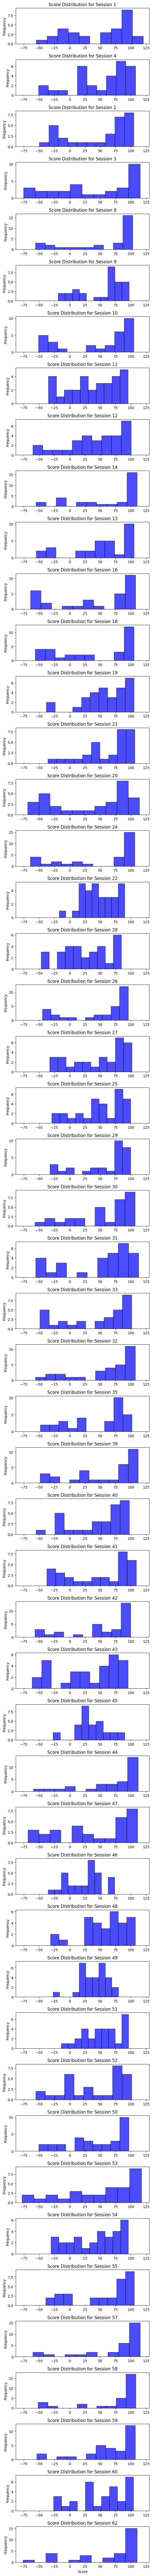

In [52]:
def plot_scores_distribution(merged_df):
    """
    Plots the distribution of scores for each participant/session ID.
    Each participant's scores are plotted separately.

    Args:
        merged_df (pd.DataFrame): DataFrame containing trial data with the following columns:
            - session_id
            - score
    """
    if "score" not in merged_df.columns or "session_id" not in merged_df.columns:
        raise KeyError("The required 'score' or 'session_id' columns are missing in merged_df.")
    
    # Get unique session IDs
    session_ids = merged_df["session_id"].unique()
    
    # Create a figure with subplots for each session
    num_sessions = len(session_ids)
    print(num_sessions)
    fig, axes = plt.subplots(num_sessions, 1, figsize=(6, 2*num_sessions), sharex=True)
    
    if num_sessions == 1:
        axes = [axes]  # Make sure axes is iterable for a single session
    
    # Plot scores for each session
    for ax, session_id in zip(axes, session_ids):
        session_scores = merged_df[merged_df["session_id"] == session_id]["score"]
        ax.hist(
            session_scores,
            bins=10,  # Adjust bins as needed
            alpha=0.7,
            color='blue',
            edgecolor='black'
        )
        ax.set_title(f"Score Distribution for Session {session_id}")
        ax.set_ylabel("Frequency")
        ax.tick_params(axis='x', which='both', labelbottom=True)  # Ensure x-ticks are visible
    
    plt.xlabel("Score")  # Set x-axis label for the entire figure
    plt.tight_layout()
    plt.show()


plot_scores_distribution(merged_df)

In [31]:
num_sessions

NameError: name 'num_sessions' is not defined